In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Dropout, Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.stats import skew, bernoulli
from bitstring import BitArray
from deap import base, creator, tools, algorithms

In [2]:
df = pd.read_csv("sp500.csv")

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.set_index(['Date'], drop=True)

In [3]:
#Converts dataframe to array
data = df.to_numpy()

#Split into training and test data
data_length = len(data)
train_split = 0.9
train_length = int(train_split * data_length)
test_length = data_length - train_length

x_train = data[0:train_length, :]
x_test = data[train_length:, :]

y_train = data[0:train_length, -1]
y_test = data[train_length:, -1]



In [4]:
#Scale Data
x_scaler = MinMaxScaler((0,1))
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler((0,1))
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))



(4227, 5)


In [5]:
def GetLabels(sequence, n_steps, window_space=1):
# Returns the sequence of labels
    label_seq = []
    for i in range(0, len(sequence), window_space):
        end_index = i + n_steps
        if end_index > len(sequence)-1:
            break
        labels = sequence[end_index]
        label_seq.append(labels)
    
    label_seq = np.array(label_seq)
    label_seq = label_seq.reshape(len(label_seq),1)
    
    return label_seq

In [6]:
def split_sequence(sequence, n_steps, window_space=1):
#Windows the data for training
    for j in range(sequence.shape[1]):
        
        data_seq = []
        for i in range(0, len(sequence[:, j]), window_space):
            end_index = i + n_steps
            if end_index > sequence.shape[0]-1:
                break
            x = sequence[i:end_index, j]
            data_seq.append(x) 
            
        data_seq = np.array(data_seq)
        data_seq = np.expand_dims(data_seq, axis=2)
        
        if j == 0:
            data = data_seq
        else:
            data = np.concatenate((data, data_seq), axis=2)    
            
    return (data)

In [7]:
def Convolutional():
#Builds the network layers
    cnn = Sequential()
    cnn.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(train_input.shape[1], train_input.shape[2])))
    cnn.add(MaxPooling1D(pool_size=2))
    cnn.add(Conv1D(filters=128, kernel_size=1, activation='relu'))
    cnn.add(MaxPooling1D(pool_size=1))
    cnn.add(Flatten())
    cnn.add(Dense(50, activation='relu'))
    cnn.add(Dense(1, activation='linear'))
    return cnn

In [8]:

#Hyper-Parameters
window_size = 4
window_space = 1
learning_rate = 0.0001
epochs = 15
batch_size = 32

#Extract train and test features
train_input = split_sequence(x_train_scaled, window_size, window_space)
test_input = split_sequence(x_test_scaled, window_size, window_space)


#Get train and test labels
train_labels = GetLabels(y_train_scaled, window_size, window_space)
test_labels = GetLabels(y_test_scaled, window_size, window_space)


#Validation Data
validation_data = (test_input, test_labels)


(4223, 4, 5)
(4223, 1)
(466, 4, 5)
(466, 1)


In [9]:
def mse(y_true, y_pred):

    loss = tf.reduce_mean(tf.losses.mean_squared_error(labels=y_true, predictions=y_pred))
    return loss

optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate)


model = Convolutional()

model.compile(loss=mse, 
              optimizer=optimiser,
              metrics=['MAE'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3, 256)            2816      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 256)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 128)            32896     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                6450      
______________________

In [10]:
history = model.fit(train_input,
                    train_labels,
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=validation_data,
                    shuffle=False)

Train on 4223 samples, validate on 466 samples
Epoch 1/15
4223/4223 [==============================] - 1s 319us/sample - loss: 0.0216 - mean_absolute_error: 0.0965 - val_loss: 0.0044 - val_mean_absolute_error: 0.0598
Epoch 2/15
4223/4223 [==============================] - 0s 75us/sample - loss: 6.1741e-04 - mean_absolute_error: 0.0197 - val_loss: 0.0044 - val_mean_absolute_error: 0.0600
Epoch 3/15
4223/4223 [==============================] - 0s 75us/sample - loss: 4.8650e-04 - mean_absolute_error: 0.0175 - val_loss: 0.0045 - val_mean_absolute_error: 0.0607
Epoch 4/15
4223/4223 [==============================] - 0s 75us/sample - loss: 4.6693e-04 - mean_absolute_error: 0.0171 - val_loss: 0.0036 - val_mean_absolute_error: 0.0546
Epoch 5/15
4223/4223 [==============================] - 0s 75us/sample - loss: 4.2597e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0032 - val_mean_absolute_error: 0.0511
Epoch 6/15
4223/4223 [==============================] - 0s 76us/sample - loss: 4.3698e-04 -

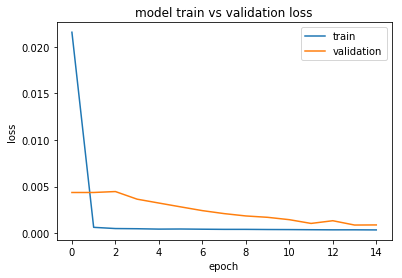

In [11]:
#Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

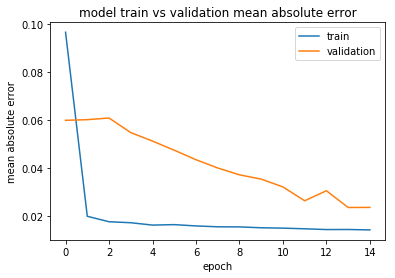

In [12]:
#Plot MAE
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model train vs validation mean absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [13]:
#Evaluate performance of test set
results = model.evaluate(x = test_input,
                        y = test_labels)
print('loss(test-set):', results)

466/466 [==============================] - 0s 45us/sample - loss: 8.7473e-04 - mean_absolute_error: 0.0235
loss(test-set): [0.0008747286598953566, 0.023454001]


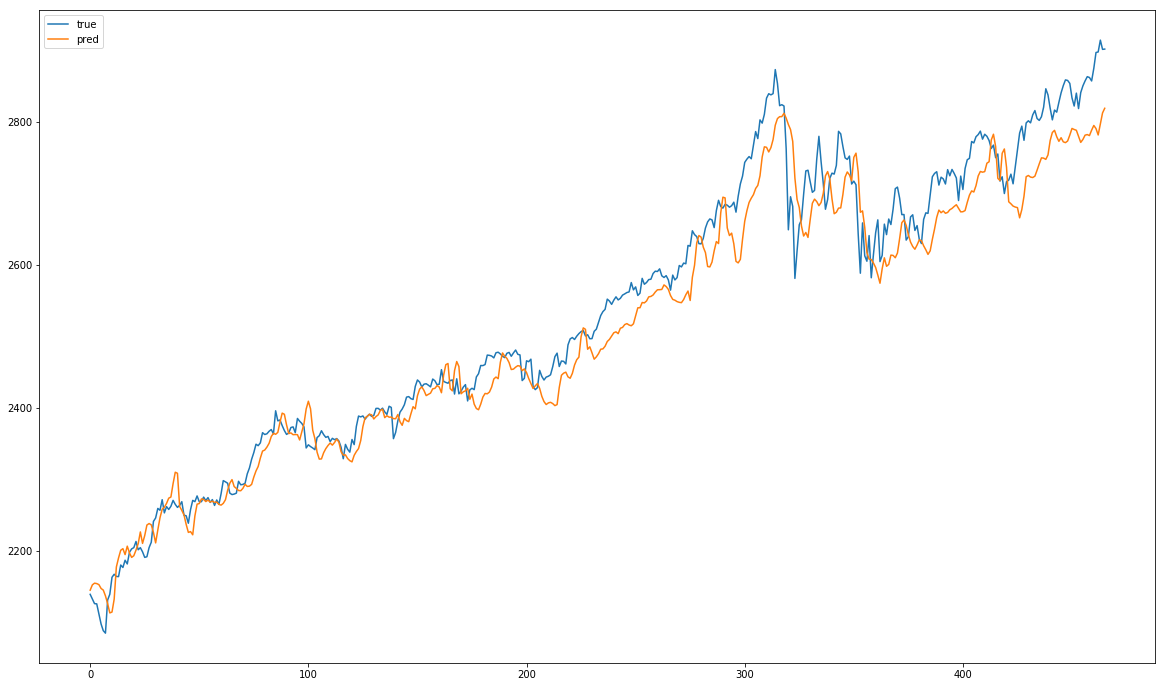

In [14]:
def plot_comparison():


    x = test_input
    #Scale labels back to ground truth
    y_true = y_scaler.inverse_transform(test_labels)
         
    # Use the model to predict the output.
    x_pred = model.predict(x)    

    x_pred = x_pred.reshape(-1,1)
    #Un normalise predicted values
    y_pred_rescaled = y_scaler.inverse_transform(x_pred)
    
    # Make the plotting-canvas bigger.
    plt.figure(figsize=(20,12))
    
    # Plot and compare the two signals.
    plt.plot(y_true, label='true')
    plt.plot(y_pred_rescaled, label='pred')
        
    # Plot labels etc.
    plt.legend()
    plt.show()
    
plot_comparison()